## Finalize short and long harmonized AnnData after Seurat SCT [M132TS Downsampling Analysis]

This notebooks takes the Seurat SCT output and previously harmonized long-reads and short-reads AnnData objects, performs a final round of filtering (e.g. doublet removal) clustering, and annotation, and outputs four analysis-ready AnnData outputs (short/long, raw/SCT)

**Inputs and Outputs**
- Inputs:
  - harmonized long-reads and short-reads AnnData objects (raw counts, all genes)
  - harmonized long-reads and short-reads AnnData objects (SCT counts, all genes) [from Seurat script]
- Outputs:
  - Four AnnData objects, each including the same cluster annotations and embeddings
    - short raw
    - short SCT
    - long raw
    - long SCT
  - Figures

In [1]:
# %matplotlib inline

import os
import sys
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import logging
from operator import itemgetter

import scanpy as sc
import anndata
from umap import UMAP

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
# load sample metadata
import yaml

with open('./downsampling_series_sample_metadata.yaml', 'r') as f:
    sample_meta_dict = yaml.safe_load(f)    

notebook_mode = True

if not notebook_mode:
    sample_key = sys.argv[1]
else:
    sample_key = 'gencode_1m'
    
log_info(f'Processing {sample_key} ...')

Processing gencode_1m ...


In [230]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'
long_tx_counts_root ='data/t-cell-vdj/long/quant/ds'
short_h5_path = 'output/t-cell-vdj-cite-seq/M132TS_immune.h5ad'
output_root = 'output/t-cell-vdj-cite-seq/ds'
fig_output_root = 'output/t-cell-vdj-cite-seq/ds/figures'
misc_output_root = 'output/t-cell-vdj-cite-seq/ds/misc'

output_prefix = 'M132TS_immune'

ADATA_SHORT_GENE_IDS_COL = 'gene_ids'
ADATA_LONG_GENE_IDS_COL = 'gencode_overlap_gene_ids'

init_leiden_resolution = 1.3
final_leiden_resolution = 1.1
n_sct_features = 5000
n_pcs = 30
n_neighbors = 100
n_neighbors_umap = 100
umap_min_dist = 0.1
umap_spread = 20.0
metric = 'euclidean'
neglect_high_expression_fraction = 0.0

In [231]:
long_tx_counts_h5_path = os.path.join(
    repo_root, long_tx_counts_root, sample_meta_dict[sample_key])

output_prefix_full = f'{output_prefix}_{sample_key}'

harmonized_long_adata_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_long.h5ad')

harmonized_short_adata_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_short.h5ad')

# it is the same for all
harmonized_short_adata_seurat_output_h5_path = os.path.join(
    repo_root, output_root, 'M132TS_immune_harmonized_short_seurat_ouput.h5ad')

harmonized_long_adata_seurat_output_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_long_seurat_output.h5ad')

final_short_adata_raw_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_final_short_raw.h5ad')

final_long_adata_raw_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_final_long_raw.h5ad')

final_short_adata_sct_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_final_short_sct.h5ad')

final_long_adata_sct_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_final_long_sct.h5ad')

## Short adata final clustering (using SCT features)

In [232]:
adata_short_raw = sc.read(os.path.join(repo_root, harmonized_short_adata_h5_path))
adata_short_seurat = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))

In [233]:
# highly variable?
adata_short_seurat.var['rv'] = np.var(adata_short_seurat.X, axis=0)
rv_cutoff = np.sort(adata_short_seurat.var['rv'])[::-1][n_sct_features]
adata_short_seurat.var['hv'] = adata_short_seurat.var['rv'] > rv_cutoff

# expression in range?
expr_cutoff = np.sort(adata_short_raw.var['mean_counts'].values)[::-1][
    int(neglect_high_expression_fraction * len(adata_short_raw.var))]
expr_in_range = adata_short_raw.var['mean_counts'] <= expr_cutoff
adata_short_seurat.var['eir'] = expr_in_range[adata_short_seurat.var.index]

# subset to highly variable and expression-in-range features
adata_short_seurat = adata_short_seurat[:, adata_short_seurat.var['hv'] & adata_short_seurat.var['eir']]

# scale
sc.pp.scale(adata_short_seurat)
sc.tl.pca(adata_short_seurat, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata_short_seurat, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

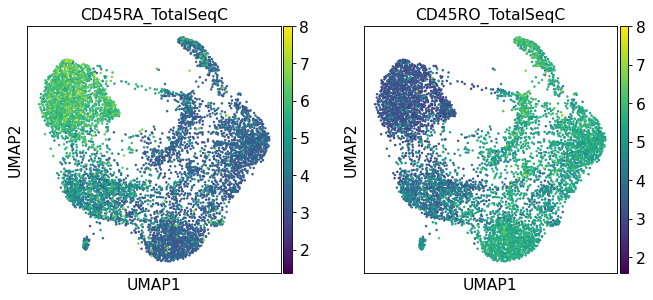

In [234]:
adata_short_seurat.obsm['X_umap'] = UMAP(
#     random_state=1,
    densmap=False,
    min_dist=umap_min_dist,
    spread=umap_spread,
    n_neighbors=n_neighbors_umap,
    metric=metric).fit_transform(adata_short_seurat.obsm['X_pca'])

adata_short_seurat.obs['CD45_TotalSeqC'] = adata_short_raw.obs['CD45_TotalSeqC']
adata_short_seurat.obs['CD45R_B220_TotalSeqC'] = adata_short_raw.obs['CD45R_B220_TotalSeqC']
adata_short_seurat.obs['CD45RA_TotalSeqC'] = adata_short_raw.obs['CD45RA_TotalSeqC']
adata_short_seurat.obs['CD45RO_TotalSeqC'] = adata_short_raw.obs['CD45RO_TotalSeqC']

sc.pl.umap(adata_short_seurat, color=['CD45RA_TotalSeqC', 'CD45RO_TotalSeqC'], s=20, vmax=8)

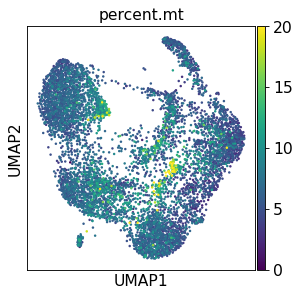

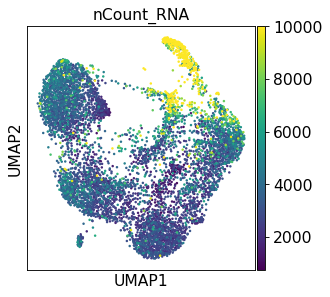

In [235]:
sc.pl.umap(adata_short_seurat, color=['percent.mt'], s=20, vmax=20)
sc.pl.umap(adata_short_seurat, color=['nCount_RNA'], s=20, vmax=10000)

## Preliminary clustering, doublet scrubbing, and proof-reading

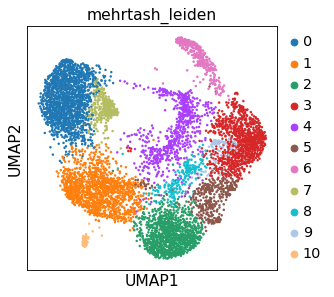

In [236]:
# todo
sc.tl.leiden(adata_short_seurat, resolution=init_leiden_resolution, key_added='mehrtash_leiden')
sc.pl.umap(adata_short_seurat, color=['mehrtash_leiden'], s=20)

# adata_short_seurat.obs['mehrtash_leiden'] = adata_short_raw.obs['moshe_leiden']

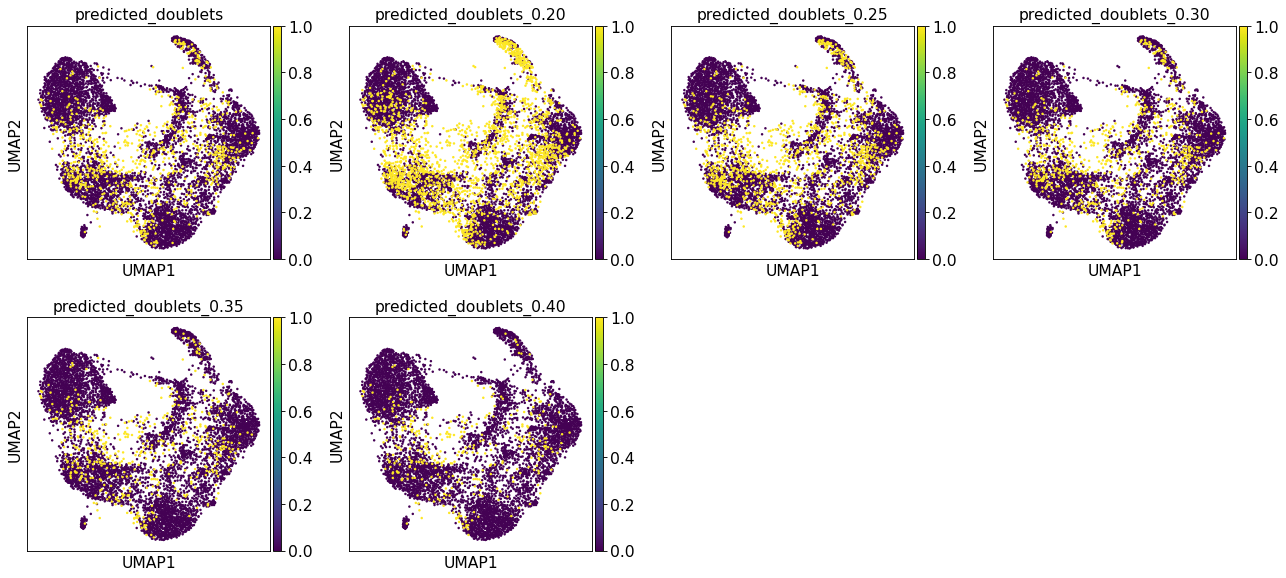

In [238]:
doublet_keys = [
    'predicted_doublets',
    'predicted_doublets_0.20',
    'predicted_doublets_0.25',
    'predicted_doublets_0.30',
    'predicted_doublets_0.35',
    'predicted_doublets_0.40'
]

sc.pl.umap(adata_short_seurat, color=doublet_keys, s=20)

In [239]:
for key in doublet_keys:
    log_info(f'{key}, doublet fraction: {np.sum(adata_short_seurat.obs[key]) / len(adata_short_seurat):.3f}')

predicted_doublets, doublet fraction: 0.140
predicted_doublets_0.20, doublet fraction: 0.311
predicted_doublets_0.25, doublet fraction: 0.188
predicted_doublets_0.30, doublet fraction: 0.127
predicted_doublets_0.35, doublet fraction: 0.083
predicted_doublets_0.40, doublet fraction: 0.058


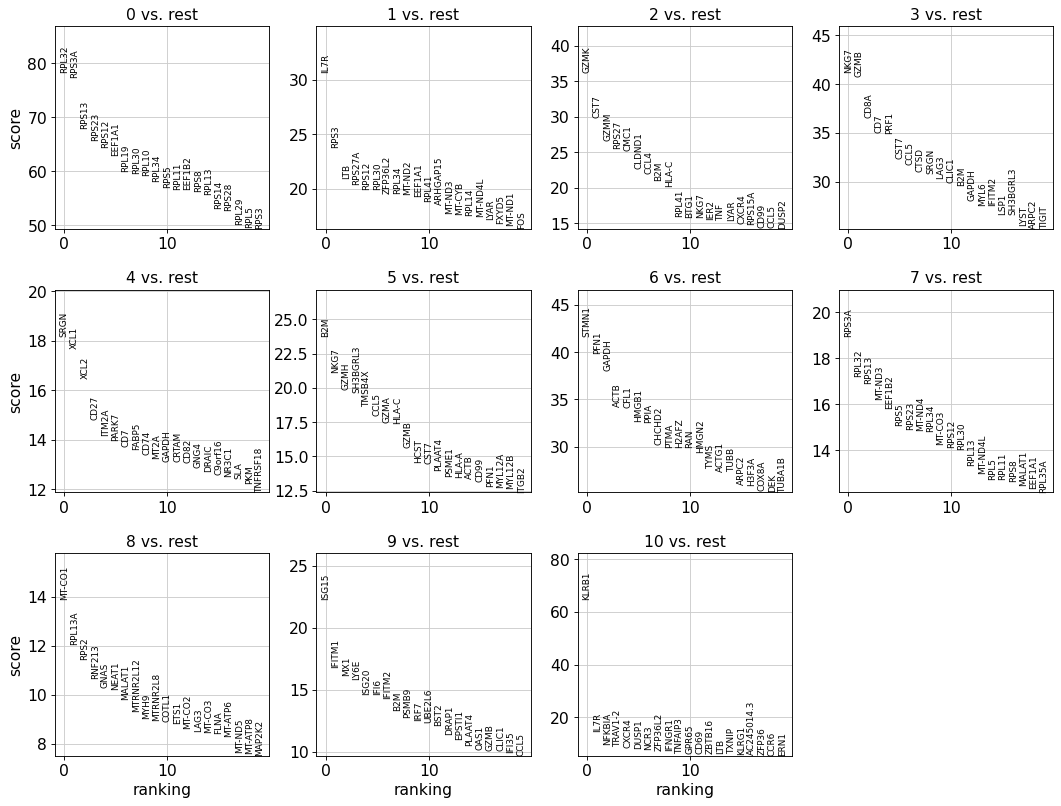

In [240]:
adata_short_seurat_full = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))
adata_short_seurat_full.obs['mehrtash_leiden'] = adata_short_seurat.obs['mehrtash_leiden']
adata_short_seurat_full.raw = None
adata_test = adata_short_seurat_full

# adata_short_raw = sc.read(os.path.join(repo_root, harmonized_short_adata_h5_path))
# adata_short_raw.obs['mehrtash_leiden'] = adata_short_seurat.obs['mehrtash_leiden']
# adata_short_raw.raw = None
# sc.pp.normalize_total(adata_short_raw, target_sum=1e4)
# sc.pp.log1p(adata_short_raw)
# sc.pp.scale(adata_short_raw)
# adata_test = adata_short_raw

sc.tl.rank_genes_groups(adata_test, 'mehrtash_leiden', method='t-test')
sc.pl.rank_genes_groups(adata_test, n_genes=20, sharey=False)

In [241]:
unwanted_leiden_ids = {
    '8', # MT- high
}

final_barcodes = adata_short_seurat[
    (~adata_short_seurat.obs['mehrtash_leiden'].isin(unwanted_leiden_ids)) &
    (~adata_short_seurat.obs['predicted_doublets_0.30'].astype(np.bool))].obs.index

## Final clustering

Trying to set attribute `.var` of view, copying.


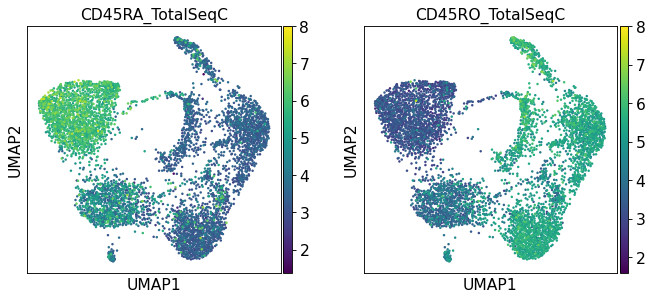

In [242]:
adata_short_raw = sc.read(os.path.join(repo_root, harmonized_short_adata_h5_path))[final_barcodes]
adata_short_seurat = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))[final_barcodes]

adata_short_seurat.var['rv'] = np.var(adata_short_seurat.X, axis=0)
rv_cutoff = np.sort(adata_short_seurat.var['rv'])[::-1][n_sct_features]
adata_short_seurat.var['hv'] = adata_short_seurat.var['rv'] > rv_cutoff
adata_short_seurat = adata_short_seurat[:, adata_short_seurat.var['hv']]

sc.pp.scale(adata_short_seurat)
sc.tl.pca(adata_short_seurat, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata_short_seurat, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

adata_short_seurat.obsm['X_umap'] = UMAP(
    random_state=1,
    densmap=False,
    min_dist=umap_min_dist,
    spread=umap_spread,
    n_neighbors=n_neighbors_umap,
    metric=metric).fit_transform(adata_short_seurat.obsm['X_pca'])

adata_short_seurat.obs['CD45_TotalSeqC'] = adata_short_raw.obs['CD45_TotalSeqC']
adata_short_seurat.obs['CD45R_B220_TotalSeqC'] = adata_short_raw.obs['CD45R_B220_TotalSeqC']
adata_short_seurat.obs['CD45RA_TotalSeqC'] = adata_short_raw.obs['CD45RA_TotalSeqC']
adata_short_seurat.obs['CD45RO_TotalSeqC'] = adata_short_raw.obs['CD45RO_TotalSeqC']

sc.pl.umap(adata_short_seurat, color=['CD45RA_TotalSeqC', 'CD45RO_TotalSeqC'], s=20, vmax=8)

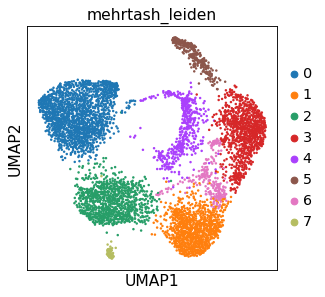

In [243]:
sc.tl.leiden(adata_short_seurat, resolution=final_leiden_resolution, key_added='mehrtash_leiden')
sc.pl.umap(adata_short_seurat, color=['mehrtash_leiden'], s=20)

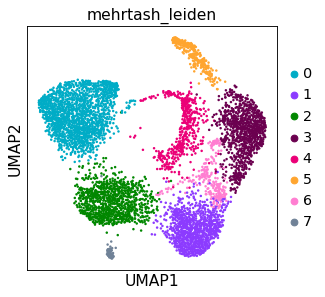

In [244]:
import colorcet as cc

def rgb_to_hex(x) -> str: 
    r = max(0, min(int(255 * x[0]), 255))
    g = max(0, min(int(255 * x[1]), 255))
    b = max(0, min(int(255 * x[2]), 255))
    return "#{0:02x}{1:02x}{2:02x}".format(r, g, b)

leiden_categories = adata_short_seurat.obs['mehrtash_leiden'].values.categories
n_leiden = len(leiden_categories)
i_order = [3, 1, 2, 6, 26, 7, 5, 33]
leiden_color_list = [rgb_to_hex(cc.cm.glasbey(i)[:3]) for i in i_order]
leiden_color_map = {
    color: category
    for category, color in zip(
        adata_short_seurat.obs['mehrtash_leiden'].values.categories,
        leiden_color_list)}

adata_short_seurat.uns['mehrtash_leiden_colors'] = leiden_color_map
sc.pl.umap(adata_short_seurat, color=['mehrtash_leiden'], s=20)

Trying to set attribute `.obs` of view, copying.


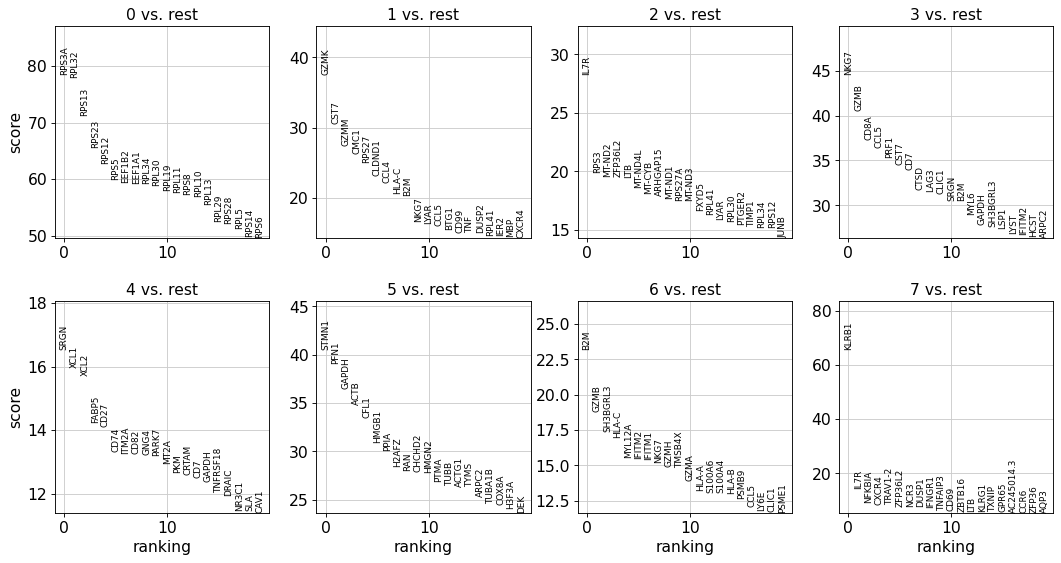

In [245]:
adata_short_seurat_full = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))[final_barcodes]
adata_short_seurat_full.obs['mehrtash_leiden'] = adata_short_seurat.obs['mehrtash_leiden']
adata_short_seurat_full.raw = None
adata_test = adata_short_seurat_full

sc.tl.rank_genes_groups(adata_test, 'mehrtash_leiden', method='t-test')
sc.pl.rank_genes_groups(adata_test, n_genes=20, sharey=False)

In [246]:
mehrtash_leiden_names_map = {
    '0': 'SMC',
    '1': 'A I',
    '2': 'EA',
    '3': 'E',
    '4': 'A III',
    '5': 'P',
    '6': 'A II',
    '7': 'A IV'
}

leiden_names = []
for leiden_id in adata_short_seurat.obs['mehrtash_leiden'].values:
    leiden_names.append(mehrtash_leiden_names_map[leiden_id])
new_color_map = {
    color: mehrtash_leiden_names_map[old_category]
    for color, old_category in adata_short_seurat.uns['mehrtash_leiden_colors'].items()}
adata_short_seurat.obs['mehrtash_leiden'] = pd.Categorical(leiden_names)
adata_short_seurat.uns['mehrtash_leiden_colors'] = new_color_map

## Long adata final clustering (using SCT features)

In [247]:
adata_long_raw = sc.read(os.path.join(repo_root, harmonized_long_adata_h5_path))[final_barcodes].copy()
adata_long_seurat = sc.read(os.path.join(repo_root, harmonized_long_adata_seurat_output_h5_path))[final_barcodes].copy()

adata_long_seurat.var['rv'] = np.var(adata_long_seurat.X, axis=0)
rv_cutoff = np.sort(adata_long_seurat.var['rv'])[::-1][n_sct_features]
adata_long_seurat.var['hv'] = adata_long_seurat.var['rv'] > rv_cutoff
adata_long_seurat = adata_long_seurat[:, adata_long_seurat.var['hv']]

sc.pp.scale(adata_long_seurat)
sc.tl.pca(adata_long_seurat, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata_long_seurat, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

In [248]:
from umap import UMAP

adata_long_seurat.obsm['X_umap'] = UMAP(
    densmap=False,
    min_dist=umap_min_dist,
    spread=umap_spread,
    n_neighbors=n_neighbors_umap,
    init=adata_short_seurat.obsm['X_umap'],
    metric=metric).fit_transform(adata_long_seurat.obsm['X_pca'])

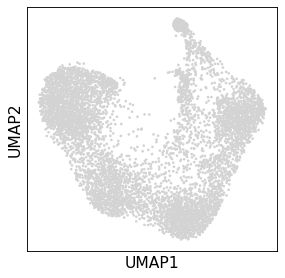

In [249]:
sc.pl.umap(adata_long_seurat)

In [250]:
adata_long_seurat.obs['CD45_TotalSeqC'] = adata_long_raw.obs['CD45_TotalSeqC']
adata_long_seurat.obs['CD45R_B220_TotalSeqC'] = adata_long_raw.obs['CD45R_B220_TotalSeqC']
adata_long_seurat.obs['CD45RA_TotalSeqC'] = adata_long_raw.obs['CD45RA_TotalSeqC']
adata_long_seurat.obs['CD45RO_TotalSeqC'] = adata_long_raw.obs['CD45RO_TotalSeqC']
adata_long_seurat.obs['mehrtash_leiden'] = adata_short_seurat.obs['mehrtash_leiden']
adata_long_seurat.uns['mehrtash_leiden_colors'] = adata_short_seurat.uns['mehrtash_leiden_colors']

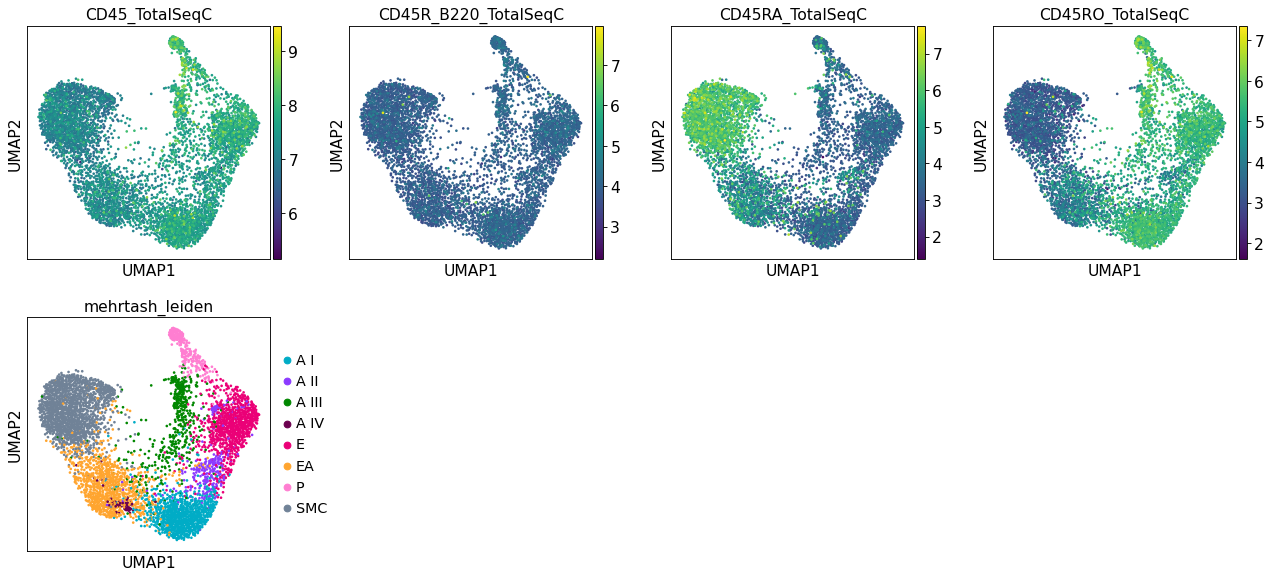

In [251]:
sc.pl.umap(adata_long_seurat, color=['CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'mehrtash_leiden'])

## Save

In [252]:
mehrtash_leiden = adata_short_seurat.obs['mehrtash_leiden']
mehrtash_leiden_colors = adata_short_seurat.uns['mehrtash_leiden_colors']

categories = mehrtash_leiden.values.categories
category_to_color = {category: color for color, category in mehrtash_leiden_colors.items()}
mehrtash_leiden_colors = list(map(category_to_color.get, categories))

adata_long_X_pca_SCT = adata_long_seurat.obsm['X_pca']
adata_long_X_umap_SCT = adata_long_seurat.obsm['X_umap']

adata_short_X_pca_SCT = adata_short_seurat.obsm['X_pca']
adata_short_X_umap_SCT = adata_short_seurat.obsm['X_umap']

In [253]:
adata_short_raw = sc.read(os.path.join(repo_root, harmonized_short_adata_h5_path))[final_barcodes]

adata_short_X_pca_raw = adata_short_raw.obsm['X_pca']
adata_short_X_tsne_raw = adata_short_raw.obsm['X_tsne']

adata_short_raw.uns.clear()
adata_short_raw.obsm.clear()

adata_short_raw.obsm['X_pca_SCT_short'] = adata_short_X_pca_SCT
adata_short_raw.obsm['X_pca_SCT_long'] = adata_long_X_pca_SCT

adata_short_raw.obsm['X_umap_SCT_short'] = adata_short_X_umap_SCT
adata_short_raw.obsm['X_umap_SCT_long'] = adata_long_X_umap_SCT

adata_short_raw.obsm['X_tsne_raw_short'] = adata_short_X_tsne_raw
adata_short_raw.obsm['X_pca_raw_short'] = adata_short_X_pca_raw

adata_short_raw.obs['mehrtash_leiden'] = mehrtash_leiden
adata_short_raw.uns['mehrtash_leiden_colors'] = mehrtash_leiden_colors

In [254]:
adata_short_sct = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))[final_barcodes]

adata_short_sct.raw = None
adata_short_sct.uns.clear()
adata_short_sct.varm.clear()
adata_short_sct.obsp.clear()
adata_short_sct.obs = adata_short_raw.obs
adata_short_sct.obsm = adata_short_raw.obsm
adata_short_sct.uns = adata_short_raw.uns
adata_short_sct.var = adata_short_raw[:, adata_short_sct.var.index].var

In [255]:
adata_long_raw = sc.read(os.path.join(repo_root, harmonized_long_adata_h5_path))[final_barcodes]
new_tx_names = [x.replace('_', '-') for x in adata_long_raw.var.index.values]
adata_long_raw.var.index = pd.Index(new_tx_names)

adata_long_raw.uns.clear()
adata_long_raw.obsm.clear()

adata_long_raw.obsm['X_pca_SCT_short'] = adata_short_X_pca_SCT
adata_long_raw.obsm['X_pca_SCT_long'] = adata_long_X_pca_SCT

adata_long_raw.obsm['X_umap_SCT_short'] = adata_short_X_umap_SCT
adata_long_raw.obsm['X_umap_SCT_long'] = adata_long_X_umap_SCT

adata_long_raw.obsm['X_tsne_raw_short'] = adata_short_X_tsne_raw
adata_long_raw.obsm['X_pca_raw_short'] = adata_short_X_pca_raw

adata_long_raw.obs['mehrtash_leiden'] = mehrtash_leiden
adata_long_raw.uns['mehrtash_leiden_colors'] = mehrtash_leiden_colors

In [256]:
adata_long_sct = sc.read(os.path.join(repo_root, harmonized_long_adata_seurat_output_h5_path))[final_barcodes]

adata_long_sct.raw = None
adata_long_sct.uns.clear()
adata_long_sct.varm.clear()
adata_long_sct.obsp.clear()
adata_long_sct.obs = adata_long_raw.obs
adata_long_sct.obsm = adata_long_raw.obsm
adata_long_sct.uns = adata_long_raw.uns
adata_long_sct.var = adata_long_raw[:, adata_long_sct.var.index].var

In [257]:
adata_short_raw.write(final_short_adata_raw_h5_path)
adata_short_sct.write(final_short_adata_sct_h5_path)
adata_long_raw.write(final_long_adata_raw_h5_path)
adata_long_sct.write(final_long_adata_sct_h5_path)

## Make paper plots

In [258]:
def plot_embedding(
        adata: sc.AnnData,
        embedding_key: str,
        leiden_key: str,
        markersize=2,
        alpha=0.75,
        x_offset=dict(),
        y_offset=dict(),
        fig=None,
        ax=None,
        figsize=(3, 3)):
    
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    leiden_color_key = f'{leiden_key}_colors'
    assert leiden_color_key in set(adata.uns.keys())

    leiden_category_to_leiden_color_map = {
        leiden_category: leiden_color
        for leiden_color, leiden_category in zip(
            adata.uns[leiden_color_key],
            adata.obs[leiden_key].values.categories)}
    cell_color_list = list(
        map(leiden_category_to_leiden_color_map.get, adata.obs[leiden_key]))

    ax.scatter(
        adata.obsm[embedding_key][:, 0],
        adata.obsm[embedding_key][:, 1],
        color=cell_color_list,
        s=markersize,
        alpha=alpha)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

    for leiden_category in adata.obs[leiden_key].values.categories:
        try:
            dx = x_offset[leiden_category]
            dy = y_offset[leiden_category]
        except KeyError:
            dx = 0
            dy = 0
        x_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 0] + dx
        y_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 1] + dy
        x_c, y_c = np.mean(x_values), np.mean(y_values)
        ax.text(
            x_c, y_c, leiden_category,
            fontsize=8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [259]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

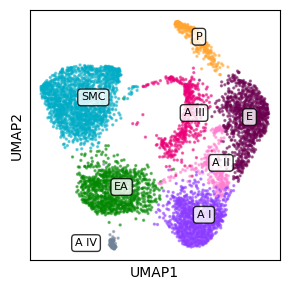

In [260]:
adata = adata_short_raw
embedding_key = 'X_umap_SCT_short'
leiden_key = 'mehrtash_leiden'
x_offset = {'A IV': -22}
y_offset = {'A IV': -2}

fig, ax = plt.subplots(figsize=(3, 3))

plot_embedding(
    adata, embedding_key, leiden_key,
    markersize=2,
    alpha=0.5,
    x_offset=x_offset,
    y_offset=y_offset,
    fig=fig,
    ax=ax)

fig.tight_layout()

plt.savefig(
    os.path.join(
        repo_root, fig_output_root, output_prefix_full + "_UMAP_short.pdf"))

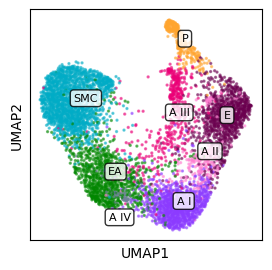

In [261]:
adata = adata_long_raw
embedding_key = 'X_umap_SCT_long'
leiden_key = 'mehrtash_leiden'
x_offset = {'A IV': -7}
y_offset = {'A IV': -16}

fig, ax = plt.subplots(figsize=(3, 3))

plot_embedding(
    adata, embedding_key, leiden_key,
    markersize=2,
    alpha=0.5,
    x_offset=x_offset,
    y_offset=y_offset,
    fig=fig,
    ax=ax)

plt.savefig(
    os.path.join(
        repo_root, fig_output_root, output_prefix_full + "_UMAP_long_with_short_labels.pdf"))

## Calculate the Adjusted Rand Index (ARI)

In [262]:
from sklearn.metrics import adjusted_rand_score

In [263]:
adata_long_sct = sc.read(os.path.join(repo_root, final_long_adata_sct_h5_path))

adata_long_sct.var['rv'] = np.var(adata_long_sct.X, axis=0)
rv_cutoff = np.sort(adata_long_sct.var['rv'])[::-1][min(n_sct_features, adata_long_sct.shape[1])]
adata_long_sct.var['hv'] = adata_long_sct.var['rv'] > rv_cutoff
adata_long_sct = adata_long_sct[:, adata_long_sct.var['hv']]

sc.pp.scale(adata_long_sct)
sc.tl.pca(adata_long_sct, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata_long_sct, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

In [264]:
adata_long_sct.obsm['X_umap'] = adata_long_sct.obsm['X_umap_SCT_long']

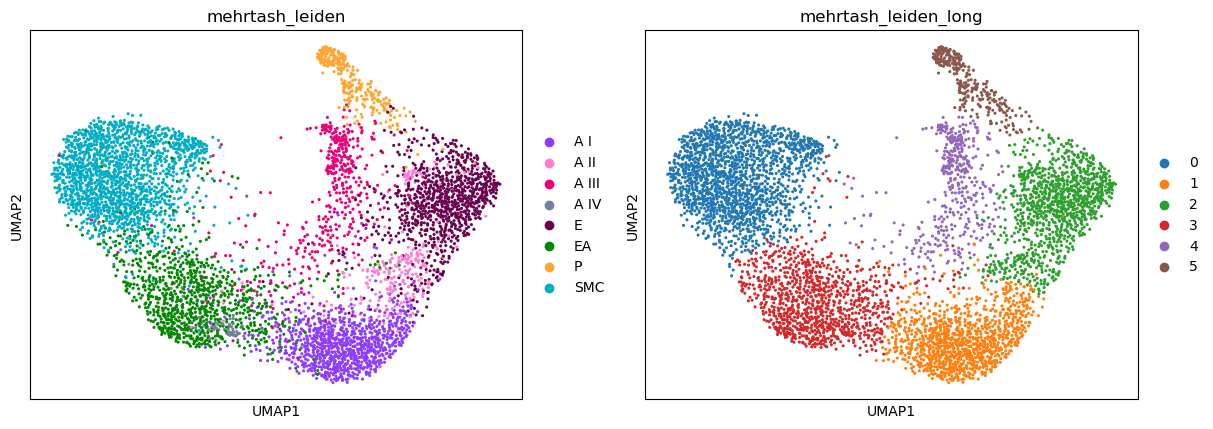

In [265]:
sc.tl.leiden(adata_long_sct, resolution=final_leiden_resolution, key_added='mehrtash_leiden_long')
sc.pl.umap(adata_long_sct, color=['mehrtash_leiden', 'mehrtash_leiden_long'], s=20)

In [266]:
mehrtash_leiden_short_to_idx_map = {
    mehrtash_leiden: idx
    for idx, mehrtash_leiden in enumerate(adata_long_sct.obs['mehrtash_leiden'].values.categories)}
mehrtash_leiden_long_to_idx_map = {
    mehrtash_leiden: idx
    for idx, mehrtash_leiden in enumerate(adata_long_sct.obs['mehrtash_leiden_long'].values.categories)}

mehrtash_leiden_short_n = list(map(mehrtash_leiden_short_to_idx_map.get, adata_long_sct.obs['mehrtash_leiden'].values))
mehrtash_leiden_long_n = list(map(mehrtash_leiden_long_to_idx_map.get, adata_long_sct.obs['mehrtash_leiden_long'].values))

In [267]:
adj_rand_score = adjusted_rand_score(mehrtash_leiden_short_n, mehrtash_leiden_long_n)
print(f'adj rand score: {adj_rand_score:.3f}')

adj rand score: 0.800


In [268]:
with open(os.path.join(repo_root, misc_output_root, output_prefix_full + "_adj_rand_score.txt"), 'w') as f:
    f.write(str(adj_rand_score) + '\n')